<center>
    <img src="https://github.com/GuitarsAI/MRSP_Notebooks/blob/master/images/msp_header.png?raw=1">
</center>

#### Prof. Dr. -Ing. Gerald Schuller <br> Jupyter Notebook: Renato Profeta

# Modified Discrete Cosine Transform (MDCT)

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/RhDB5yKdU5s?rel=0" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

Last time we saw that para-unitary polyphase matrices are an easy way to obtain the inverse polyphase matrix for the synthesis (we just need to transpose the matrix and replace z by $z^{−1}$ ). But how do we obtain useful para-unitary polyphase matrices or filter banks? (more useful than a simple transform matrix)

We now go one step further in **increasing the length** of our polynomials in the polyphase matrix. We saw that zero'th order polynomials result in our usual transform matrices, like a DCT. But we already know their frequency responses are often not good enough. 

The next step is to look at polynomials of **first order**, where we have elements $z^{−1}$ .

This then leads to impulse response with a length of **2 blocks** (the first block correponds to a delay of $z^0$ , the second block to $z^{−1}$ ). Hence we get the impulse response length of **L=2N** (with N the block length and the number of subbands).

One wide-spread example are the so-called **MDCT** (Modified Discrete Cosine Transform) filter banks, which are so-called cosine modulated filter banks.

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/NxOZWDCYy1E?rel=0" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

As we saw (Lecture 6), modulation means the multiplication of a baseband prototype filter impulse response with a periodic **modulation** function, here a cosine function. In this way, all the subband filters are obtained from one prototype filter h(n) , in this case for the **analysis filters**, as

$$\large
\begin{equation}
h_k(n) = h(n) \cdot \sqrt{\frac{2}{N}} \cdot \cos \left( \frac{\pi}{N} \cdot \left( k+ \frac{1}{2} \right) 
\cdot \left( n + \frac{N}{2} + \frac{1}{2} \right)
\right)
\end{equation}
$$

for the subbands k=0,...,N-1, and time index n=0,..., 2N-1, meaning we have filters of length **L=2N.**

The prototype filter h(n) is a low pass filter, and the cos() modulation function shifts the center frequency of the filter to the cosine function frequencies $\left(\frac{\pi}{N} \cdot (k+0.5) \right)$, such that we evenly cover the entire frequency range from 0 to $\pi$ .

Imagine the lowpass having a pass band from $\frac{−\pi}{2N}$ to $\frac{\pi}{2N}$ then the first subband, for k=0, already results from modulation with frequency $\frac{\pi}{2N}$ and hence it goes on the positive side from 0 to $\frac{\pi}{N}$. In this way we obtain N filter of passband width $\frac{\pi}{N}$ , which then cover the entire frequency range between 0 and $\pi$ in the positive frequency range (the negative frequencies are the mirrored version).

Observe that we can view eq. (1), the multiplication of h(n) with the cos term, also as a window design method. Here the ideal
filter would not be the sinc function, but an infinitely long cosine function. This corresponds to infinitely narrow bandpass filters at the cosine frequencies as ideal filters. After windowing they then become wider.

Because of those 2 different views, we see 2 different names in literature for h(n):
 - "baseband prototype"
 - "window function" (time-reversed baseband prototype).

## Python Example Filters

Take the so-called sine window or baseband prototype for N=8 subbands:

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/STWybhOAM8Q?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

In [ ]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as signal

Text(0.5, 1.0, 'Sine Window')

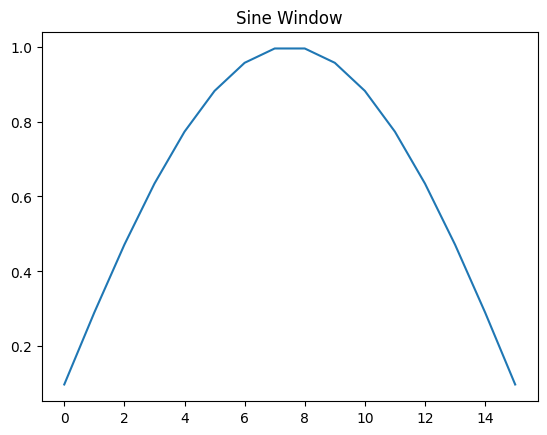

In [ ]:
N=8        # Block Size, subbands
L=2*N      # Length of the Filter
M = L//N   # Number of blocks in the Filter

# Sine window
h = np.sin((np.pi/L)*(np.arange(L)+0.5)) #Sine window Impulse Response
plt.plot(h)
plt.title('Sine Window')

In [ ]:
hk=np.zeros((L,N))
for n in range(L):
    for k in range(N):
        hk[n,k]=h[n]*np.sqrt(2/N)*np.cos((np.pi/N)*(k+0.5)*(n+N/2+0.5))

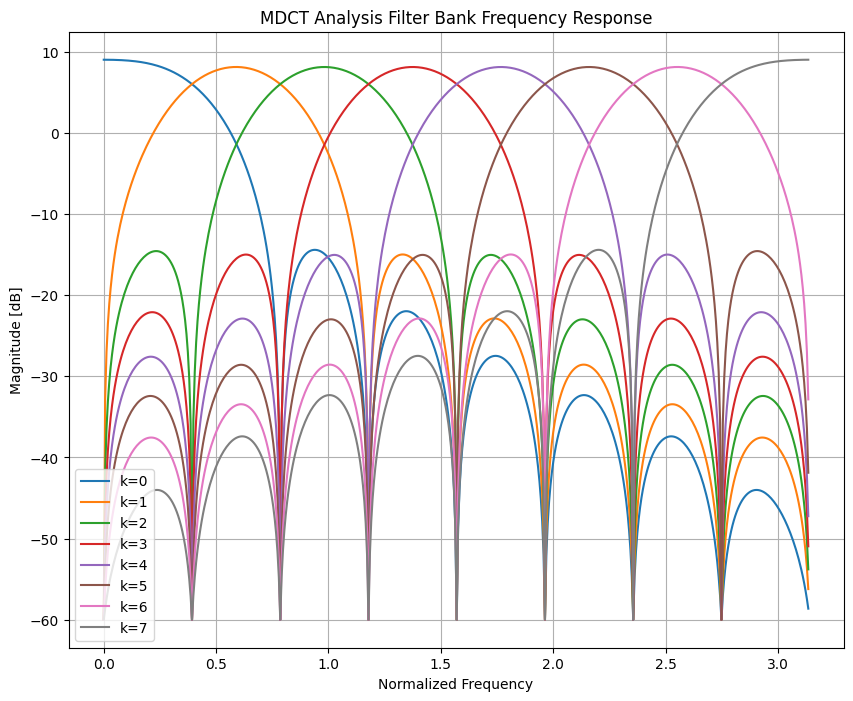

In [ ]:
# Plot the Filters Frequency Response
plt.figure(figsize=(10,8))
plt.grid()
plt.title('MDCT Analysis Filter Bank Frequency Response')
plt.ylabel('Magnitude [dB]')
plt.xlabel('Normalized Frequency')

for k in range(N):
    w, H = signal.freqz(np.flipud(hk[:,k]), whole=False)
    plt.plot(w, 20*np.log10(np.abs(H)+1e-3),label='k=%d'%(k))
plt.legend(loc=3);

We see that h is indeed a low pass filter. It works as both, a window and a low pass prototype filter.

We see that our low pass filter h is indeed shifted in frequency h(n,k) to become bandpass filters and a highpass filter.

So the baseband prototype or window h(n) is all what we need for the design of our filter bank.

h(n) is a lowpass, which we want to design now with the **goal** that we get **high stopband attenuation** and also obtain **perfect reconstruction.**

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/wDm4mj6H2Oc?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

For the **synthesis filters**, we have the baseband prototype filter g(n) which produces the subband filters:


$$\large
g_k(n) = g(n) \cdot \sqrt{\frac{2}{N}} \cdot \cos \left( \frac{\pi}{N} \cdot \left( k+ \frac{1}{2} \right) 
\cdot \left( n - \frac{N}{2} + \frac{1}{2} \right)
\right)
$$

How do we now design the prototype filters h(n) and g(n) such that we obtain **perfect reconstruction**? 

At this point it is not clear if it even works with the modulation constraint we just introduced. To see that, we first construct the polyphase matrices. First the analysis, we get its elements as:

$$\large
H_{n,k} = \sum_{m=0}^{\frac{L}{N-1}} h_k(mN+n) \cdot z^{-m} = \\
\large
h_k(n)+h_k(N+n) \cdot z^{-1}
$$

Observe that the upper limit of our summation index was $\frac{L}{N-1}$, hence it is 1 here since L=2N (we have 2 blocks, block 0 and block 1). This means we only have 2 summands, for m=0 and m=1.

For the synthesis polyphase matrix we get:

$$\large
G_{n,k} = \sum_{m=0}^{\frac{L}{N-1}} g_k(mN+n) \cdot z^{-m} = \\
\large
g_k(n)+g_k(N+n) \cdot z^{-1}
$$

In this way we obtain the analysis polyphase matrix as:

$$\large
H_{MDCT}(z)
=\left[ 
        \begin{array}{ccc} 
            H_{N-1,0}(z) & H_{N-1,1}(z) & \dots & H_{N-1,N-1}(z) \\ 
            H_{N-2,0}(z) & \dots & \dots & \vdots \\
            \vdots & \dots & \ddots & \vdots \\ 
            H_{0,0}(z) & \dots & \dots & H_{0,N-1}(z) 
        \end{array}
    \right]
$$

$$\large
\begin{equation}
= \left[ 
        \begin{array}{ccc} 
            h_0(N-1)+h_0(2N-1)\cdot z^{-1} & \dots & \dots & h_{N-1}(N-1)+h_{N-1}(2N-1)\cdot z^{-1} \\ 
            h_0(N-2)+h_0(2N-2)\cdot z^{-1} & \dots & \dots & \vdots \\
            \vdots & \dots & \ddots & \vdots \\ 
            h_0(0)+h_0(N) \cdot z^{-1} & \dots & \dots & h_{N-1}(0)+h_{N-1}(N) \cdot z^{-1} 
        \end{array}
    \right]
\end{equation}
$$


Observe that we here only have polynomials of first order as elements of our polyphase matrix.
Similar for the synthesis, we get:

$$\large
G_{MDCT}(z)
= \left[ 
        \begin{array}{ccc}
            g_0(0)+g_0(N) \cdot z^{-1} & \dots & \dots & g_0(N-1)+g_0(2N-1) \cdot z^{-1} \\
            g_1(0)+g_1(N) \cdot z^{-1} & \dots & \dots & \vdots \\ 
            \vdots & \dots & \ddots & \vdots \\
            g_{N-1}(0)+g_{N-1}(N)\cdot z^{-1} & \dots & \dots & g_{N-1}(N-1)+g_{N-1}(2N-1) \cdot z^{-1}
        \end{array}
    \right]
$$

**Observe** the corresponding time/phase indices for the analysis and synthesis polyphase matrix, which run the transpose way for the synthesis.

The problem is that we still don't know how to proceed with the design of our prototype filters. We basically could start constructing an **analysis polyphase matrix**, and then invert it to obtain **perfect reconstruction**. But the inverse of a polynomial matrix is not so easy to compute, and also the inverse polyphase matrix might have filters which are not "good" (for instance no real passband or not sufficient stopband attenuation, or we get IIR filters instead of FIR filters).

But here, a trick helps. Since we have a modulated filter bank, we have certain periodicities hidden in the impulse responses and hence on the polyphase matrix. It is possible to investigate those periodicities manually, and come up with a solution for perfect reconstruction, as Princen and Bradley did in the late 80's, who first described the MDCT, which they called **TDAC then (Time Domain Aliasing Cancellation)**, because that was the approach they used. 

They analyzed all the aliasing components in the time domain and found one condition to cancel them in the time domain. This lead to the **sine window**. Later people, especially in the MPEG context, called it MDCT.

### Python example for the symmetries of a longer cosine modulation function:

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/cdRWDgJ7RHU?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

Take a modulated analysis filter bank with impulse responses: 

$$\large
h_k(n) = h(n) \cdot \cos \left( \frac{\pi}{8} \cdot \left( k+ \frac{1}{2} \right) 
\cdot \left( n  + \frac{1}{2} \right)
\right)
$$

with a cosine modulation function like a DCT4. For subband k=0, for N=8 subbands, and for a length of 32, we get:

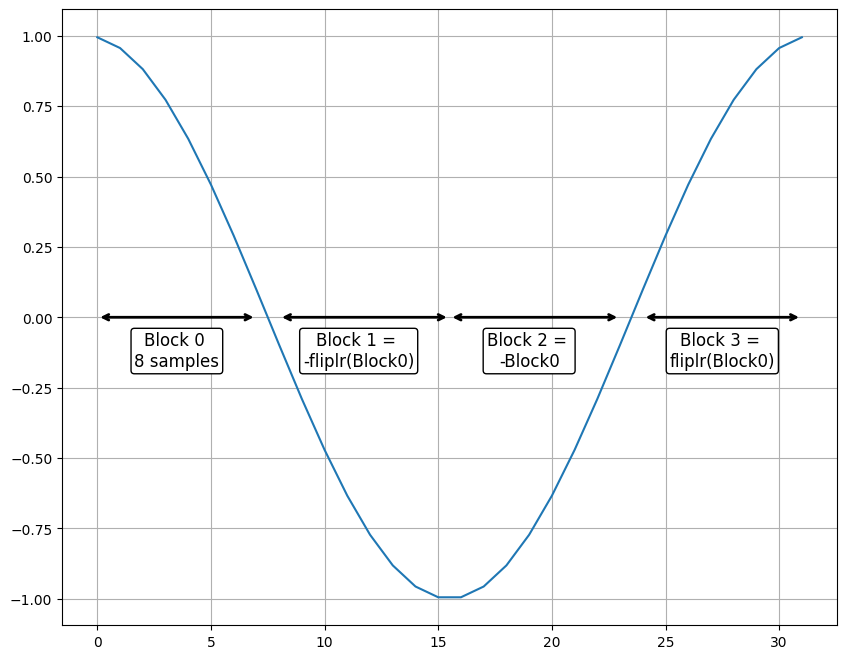

In [ ]:
c=np.cos(np.pi/8*0.5*(np.arange(32)+0.5))
plt.figure(figsize=(10,8))
plt.plot(c)

plt.annotate("", xy=(0, 0), xytext=(7, 0),
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", linewidth=2))
plt.text(3.5, -0.12, "Block 0 \n8 samples",
         {'color': 'black', 'fontsize': 12, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
plt.annotate("", xy=(8, 0), xytext=(15.5, 0),
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3",linewidth=2))
plt.text(11.5, -0.12, "Block 1 = \n-fliplr(Block0)",
         {'color': 'black', 'fontsize': 12, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
plt.annotate("", xy=(15.5, 0), xytext=(23, 0),
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3",linewidth=2))
plt.text(19, -0.12, "Block 2 = \n-Block0",
         {'color': 'black', 'fontsize': 12, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
plt.annotate("", xy=(24, 0), xytext=(31, 0),
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", linewidth=2))
plt.text(27.5, -0.12, "Block 3 = \nfliplr(Block0)",
         {'color': 'black', 'fontsize': 12, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
plt.grid()


This image visualizes the following symmetrie:

In [ ]:
c[0:8]

array([0.99518473, 0.95694034, 0.88192126, 0.77301045, 0.63439328,
       0.47139674, 0.29028468, 0.09801714])

The second block is identical to flipping and negating the first block:

In [ ]:
c[8:17]

array([-0.09801714, -0.29028468, -0.47139674, -0.63439328, -0.77301045,
       -0.88192126, -0.95694034, -0.99518473, -0.99518473])

In [ ]:
-np.flip(c[0:8])

array([-0.09801714, -0.29028468, -0.47139674, -0.63439328, -0.77301045,
       -0.88192126, -0.95694034, -0.99518473])

The third block is identical to negating the first block:

In [ ]:
c[16:24]

array([-0.99518473, -0.95694034, -0.88192126, -0.77301045, -0.63439328,
       -0.47139674, -0.29028468, -0.09801714])

In [ ]:
-c[0:8]

array([-0.99518473, -0.95694034, -0.88192126, -0.77301045, -0.63439328,
       -0.47139674, -0.29028468, -0.09801714])

The last block is identical to flipping the first block:

In [ ]:
c[24:]

array([0.09801714, 0.29028468, 0.47139674, 0.63439328, 0.77301045,
       0.88192126, 0.95694034, 0.99518473])

In [ ]:
np.flip(c[0:8])

array([0.09801714, 0.29028468, 0.47139674, 0.63439328, 0.77301045,
       0.88192126, 0.95694034, 0.99518473])

And so on. We see the following rule: **Every second block is flipped, and after 2 blocks we get a sign change.**

This is not only true for the first subband, but also for all other subbands k.

To show how this is useful for a matrix implementation, the following example:

We have a prototype function h(n) and N=4 subbands.

Then our modulated impulse response for subband k=0 with the basic DCT4 cosine modulation function is:

$$\large
h_0(n) = h(n) \cdot \cos \left( \frac{\pi}{4} \cdot 0.5 \cdot \left( n+0.5 \right) \right)
$$

(to show the basic principle, the time shift of the MDCT was omitted)

Now we can implement it with blocks of size 4. For a filter length of 8 (twice as long as the DCT4) we have 2 modulated blocks (with block number 0 and 1), with time reversal for the analysis, for $h_0$ :

$$\large
h_0(0) := [h_0(3),h_0(2),h_0(1),h_0(0)] \\
\large
h_0(1) := [h_0(7), h_0(6),h_0(5),h_0(4)]
$$

Now we can write the modulation with length 2N with our cosine function with the help of a matrix formulation, which includes the flipping and sign change of the second cosine modulation block. For that we also define the first block of our cos modulation function as:

$$\large
T_0 := fliplr \left( \cos \left( \frac{\pi}{4} \cdot 0.5 \cdot \left( (0:3)+0.5 \right) \right) \right) 
$$

Observe that $T_0^T$ is also the **first column** of our **DCT4** transform matrix.

Hence, for the first block of the modulated impulse response we simply get:

$$\large
\mathbf h_0(0)
=\left[ 
        \begin{array}{ccc} 
            h(3) & 0 & \dots & \dots \\ 
            0 & h(2) & \dots & \vdots \\
            \vdots & \dots & h(1) & \vdots \\ 
            \vdots & \dots & \dots & h(0) 
        \end{array}
    \right] \cdot \mathbf T_0^T
$$
$$\large
 = \left[ h(n) \cdot \cos \left( \frac{\pi}{4} \cdot 0.5 \cdot \left( n+0.5 \right) \right) \right]_{n=0,...,3}
$$

Because the second modulation block (block 1) is time-flipped and sign changed compared to the first (block 0), we obtain our second modulated block as. Instead of flipping and changing the sign of our modulation vector $\mathbf T_0$ , we apply the flipping and sign change to the matrix of the prototype function,

$$\large
\mathbf h_0(1)
=\left[ 
        \begin{array}{ccc} 
            \dots & 0 & \dots & -h(7) \\ 
            0 & \dots & -h(6) & \vdots \\
            \vdots & -h(5) & \dots & \vdots \\ 
            -h(4) & \dots & \dots & \dots 
        \end{array}
    \right] \cdot \mathbf T_0^T
$$
$$\large
 = \left[ -h(4) \cdot \cos \left( \frac{\pi}{4} \cdot 0.5 \cdot \left( 3+0.5 \right) \right),
 -h(5) \cdot \cos \left( \frac{\pi}{4} \cdot 0.5 \cdot \left( 2+0.5 \right) \right), \dots
 \right]
$$

Hence we can put both together in the z-domain as:

$$\large
\mathbf h_0(0) + z^{-1} \mathbf h_0(1)
=\left[ 
        \begin{array}{ccc} 
            h(3) & 0 & \dots & -h(7)z^{-1} \\ 
            0 & h(2) & -h(6)z^{-1} & \vdots \\
            \vdots & -h(5)z^{-1} & h(1) & \vdots \\ 
            -h(4)z^{-1} & \dots & \dots & h(0) 
        \end{array}
    \right] \cdot \mathbf T_0^T
$$

observe that we can simply add the 2 previous matrices since they have the same size and we can factor out the vector of the modulation function $T_0$ , and multiply the second block with a $z^{-1}$ to obtain the z-transform.

We see that we obtain a very compact representation for the modulation, where we **separated the prototype function and the modulation function** into 2 different matrices, and the matrix with the prototype function is a sparse matrix.

If the extend this example to filters of length 4 blocks, we get:

$$\large
h_0(0) + z^{-1}h_0(1)+z^{-2}h_0(2)+z^{-3}h_0(3) = \\ 
\large
\left[ 
        \begin{array}{ccc} 
            h(3) - z^{-2}h(11) & 0 & \dots & -h(7)z^{-1}+h(15)z^{-3} \\ 
            0 & h(2)- z^{-2}h(10) & -h(6)z^{-1} +h(14)z^{-3} & \vdots \\
            \vdots & -h(5)z^{-1} + h(13)z^{-3} & h(1) - z^{-2}h(9) & \vdots \\ 
            -h(4)z^{-1}+h(12)z^{-3} & \dots & \dots & h(0)-z^{-2}h(8)
        \end{array}
    \right] \cdot \mathbf T_0^T
$$

We can see that this is a **cross-shaped** matrix.

**Observe:** Every polynomial in this resulting matrix is a **downsampled** version of the prototype h(n) by a factor of **2N**! (in our case 2N=8). In addition, every second resulting value after this downsampling is also sign changed (we can also obtain this sign change by replacing $z^2$ by $-z^{2}$ in the z-transform for the 2N downsampled versions).

So this matrix times our column vector $T_0^T$ above results in the polyphase representation of our subband filter $h_0(n)$ for the subband k=0. So this is the first of 4 filters we have in our modulated filter bank.

We obtain all 4 filters if we just use the complete DCT4 transform matrix **T** , with:

$$\large
T_{n,k} = \cos \left(\frac{\pi}{N} \cdot (n+0.5)\cdot(k+0.5)\right)
$$, for (n,k) = 0,...,N-1

For instance, with N=4 we get for T ,

In [69]:
import sympy
T= sympy.zeros(4, 4)

for n in range(4):
    for k in range(4):
        T[n,k]=np.cos((np.pi/4)*(n+0.5)*(k+0.5))

display(T)

Matrix([
[ 0.98078528040323,  0.831469612302545, 0.555570233019602,  0.195090322016128],
[0.831469612302545, -0.195090322016128, -0.98078528040323, -0.555570233019602],
[0.555570233019602,  -0.98078528040323, 0.195090322016128,  0.831469612302545],
[0.195090322016128, -0.555570233019602, 0.831469612302545, -0.980785280403231]])

Fortunately, we obtain the same symmetries as for the first subband also for the higher subbands.

**Summary:**
If we have an analysis filter bank with impulse responses:

$$\large
h_k(n) = h(n) \cdot \cos \left( \frac{\pi}{4} \cdot (k+0.5) \cdot \left( n+0.5 \right) \right)
$$

its analysis **polyphase matrix H(z)** can be written as a **multiplication of a sparse cross shaped matrix** with a DCT4 transform matrix **T** as:

$$\large
H(z) = \\ 
\large
\left[ 
        \begin{array}{ccc} 
            h(3) - z^{-2}h(11) & 0 & \dots & -h(7)z^{-1}+h(5)+h(15)z^{-3} \\ 
            0 & h(2)- z^{-2}h(10) & -h(6)z^{-1} +h(14)z^{-3} & \vdots \\
            \vdots & -h(5)z^{-1} + h(13)z^{-3} & h(1) - z^{-2}h(9) & \vdots \\ 
            -h(4)z^{-1}+h(12)z^{-3} & \dots & \dots & h(0)-z^{-2}h(8)
        \end{array}
    \right] \cdot T_0^T
$$

For odd numbers of subbands N we would obtain one value or polynomial in the center of the matrix.

## Sparse Matrices and the MDCT

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/-3LM3DE_UC4?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

Remember, the MDCT analysis impulse responses are:

$$\large
\begin{equation} \tag{2b}
h_k(n) = h(n) \cdot \sqrt{\frac{2}{N}} \cdot \cos \left( \frac{\pi}{N} \cdot \left( k+ \frac{1}{2} \right) 
\cdot \left( n + \frac{N}{2} + \frac{1}{2} \right)
\right)
\end{equation}
$$

and the filter length here is limited to 2N, meaning n=0,...,2N-1. Since the MDCT has a very similar modulation function as the DCT4, just with a time shift of N/2 in it, we suspect that we can also factor it into a sparse matrix and the DCT4 transform matrix, as:

$$\large
H_{MDCT}(z) = F_a(z)\cdot T
$$

with some sparse matrix $F_a(z)$ . If this assumption is true, we can obtain the sparse matrix by bringing the transform matrix in above formula on the other side,

$$\large
F_a(z)=H_{MDCT}(z) \cdot T^{-1}
$$

We can simply start with constructing the complete polyphase matrix $H_{MDCT}(z)$ using eq. (1), (2), plugging in the definition of $h_k$ (n) (2b), and then compute $F_a(z)$ as follows:

$$\large
\begin{equation} \tag{3}
H_{MDCT}(z) \cdot T^{-1} = \\ 
\large
\left[ 
        \begin{array}{ccccc} 
            . & . & -z^{-1}\cdot h(2N-1) & -h(N-1) & . & 0 \\ 
            0 & \vdots & 0 & . & \vdots & . \\
            -z^{-1} \cdot h(1.5 N) & . & 0 & . & . & -h(0.5 N) \\ 
            -z^{-1} \cdot h(1.5 N-1) & . & . & 0 & . & -h(0.5 N -1) \\
            0 & \vdots & . & . & \vdots & . \\
            0 & . & z^{-1} \cdot -h(N) & h(0) & . & 0 \\
        \end{array}
    \right]
    \end{equation}
$$

This is for the simple case of a **filter length of just 2N**, which is the length of a MDCT.

For odd numbers of subbands N we would get one value or polynomial in the top and bottom row centers and the left- and right most columns.

**Observe** that we now have **all delays on the left hand side** of the matrix, which allows us to **factor them out** into a diagonal matrix later!

### Python Computation

We can try out this factorization for instance with the symbolic Math package **“sympy”** for **Python**.

Observe that exponentiation in Python is symbolized with two stars, “**”.

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/_BO-yVaWWOE?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

In [59]:
#Example for the extraction of the Fa Matrix from the MDCT polyphase matrix
import sympy
#from scipy import *
import numpy as np

In [60]:
z=symbols('z')
N=4
#baseband prototype filter h(n):
h=symbols('h:8');
print( "h=")
print(h)

h=
(h0, h1, h2, h3, h4, h5, h6, h7)


In [61]:
#MDCT Polyphase matrix H. Since each column contains the time-reversed impulse response,
#we need the "N-1-n" instead of the "n":
#start with a NxN matrix of zeros:
print("N=", N)

H=sympy.zeros(N,N);
#range(0,N) produces indices from 0 to N-1.
#We compute H using eq. (1) and (2):
for n in range(0,N):
    for k in range(0,N):
        H[n,k]=h[N-1-n]*np.cos(np.pi/N*(N-1-n+N/2+0.5)*(k+0.5)) + z**(-1)*h[2*N-1-n]*np.cos(np.pi/N*(2*N-1-n+N/2+0.5)*(k+0.5))

print("H(z)=", H) 
#Transform matrix T for the DCT4:
T=sympy.zeros(N,N);
for n in range(0,N):
    for k in range(0,N):
        T[n,k]=np.cos(np.pi/N*(n+0.5)*(k+0.5));
print("Compute the sparse Fa matrix:")
Faz= H*(T.inv())

#Print the H matrix with 1 digit after the decimal point and replacement of very small number by 0:
print( "H(z)=")
display( H.evalf(1,chop=True))

#Print the Fa matrix with 1 digit after the decimal point and replacement of very small number by 0:
print( "Faz=")
display(nsimplify(Faz,tolerance=1e-10,rational=True))

N= 4
H(z)= Matrix([[-0.555570233019602*h3 - 0.831469612302545*h7/z, 0.980785280403231*h3 + 0.195090322016127*h7/z, -0.19509032201613*h3 + 0.98078528040323*h7/z, -0.831469612302544*h3 + 0.555570233019606*h7/z], [-0.195090322016128*h2 - 0.98078528040323*h6/z, 0.555570233019602*h2 - 0.831469612302545*h6/z, -0.831469612302545*h2 - 0.555570233019603*h6/z, 0.98078528040323*h2 - 0.195090322016127*h6/z], [0.195090322016128*h1 - 0.98078528040323*h5/z, -0.555570233019602*h1 - 0.831469612302544*h5/z, 0.831469612302545*h1 - 0.555570233019602*h5/z, -0.980785280403231*h1 - 0.195090322016125*h5/z], [0.555570233019602*h0 - 0.831469612302545*h4/z, -0.98078528040323*h0 + 0.195090322016128*h4/z, 0.195090322016128*h0 + 0.98078528040323*h4/z, 0.831469612302545*h0 + 0.555570233019604*h4/z]])
Compute the sparse Fa matrix:
H(z)=


Matrix([
[-0.6*h3 - 0.8*h7/z,  1.0*h3 + 0.2*h7/z, -0.2*h3 + 1.0*h7/z, -0.8*h3 + 0.6*h7/z],
[-0.2*h2 - 1.0*h6/z,  0.6*h2 - 0.8*h6/z, -0.8*h2 - 0.6*h6/z,  1.0*h2 - 0.2*h6/z],
[ 0.2*h1 - 1.0*h5/z, -0.6*h1 - 0.8*h5/z,  0.8*h1 - 0.6*h5/z, -1.0*h1 - 0.2*h5/z],
[ 0.6*h0 - 0.8*h4/z, -1.0*h0 + 0.2*h4/z,  0.2*h0 + 1.0*h4/z,  0.8*h0 + 0.6*h4/z]])

Faz=


Matrix([
[    0, -h7/z, -h3,   0],
[-h6/z,     0,   0, -h2],
[-h5/z,     0,   0,  h1],
[    0, -h4/z,  h0,   0]])

Here we see that it is the same as eq. (3), apart from rounding errors, and that we get a diamond matrix shape. This **diamond shape** results from the **time-shift of $\mathbf{\frac{N}{2}}$** in the cos modulation function. It has the effect of shifting the left and the right halves of the above cross shaped matrix (and multiplying it with $z^{−1}$ ).

The result of shifting or exchanging those 2 halves is this diamond shaped matrix we can see here.

This matrix is now surprisingly simple, it only contains the 2N samples of our baseband prototype impulse response. **Most entries are zero**, and we have **delays $\mathbf{z^{−1}}$ only on the left hand side**. This was the purpose of the
summand $\frac{N}{2}$ on the *cos* modulation function.

In this way we can factor out the delays in the following “Delay Matrix”, which is important for invertibility and perfect reconstruction! 

The particular diamond shape of the matrix results from the symmetries of the cosine modulation, and the shift of $\frac{N}{2}$ on the modulation function for the time index.

## The Delay Matrix

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/5epUcUcOn5s?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

The next step is to factor out the delays, for which we use the following delay matrix:

$$\large
D(z)
=\left[ 
        \begin{array} {cccccc}
            z^{-1} & 0 & . & . & . & 0 \\ 
            0 & \ddots & 0 & . & . & . \\
            . & 0 & z^{-1} & 0 & . & . \\ 
            . & . & 0 & 1 & 0 & . \\ 
            . & 0 & . & . & \ddots & . \\
            0 & . & . & . & 0 & 1
        \end{array}
    \right] 
$$

For a faster (non-sympy) implementation in Python we can again write this as a polynomial with matrix coefficients,

$$\large
D(z)
=\left[ 
        \begin{array} {cccccc}
            0 & 0 & . & . & . & 0 \\ 
            0 & \ddots & 0 & . & . & . \\
            . & 0 & 0 & 0 & . & . \\ 
            . & . & 0 & 1 & 0 & . \\ 
            . & 0 & . & . & \ddots & . \\
            0 & . & . & . & 0 & 1
        \end{array}
    \right] \cdot z^0 +
\left[ 
        \begin{array} {cccccc}
            1 & 0 & . & . & . & 0 \\ 
            0 & \ddots & 0 & . & . & . \\
            . & 0 & 1 & 0 & . & . \\ 
            . & . & 0 & 0 & 0 & . \\ 
            . & 0 & . & . & \ddots & . \\
            0 & . & . & . & 0 & 0
        \end{array}
    \right]   \cdot z^{-1}
$$

and store these matrix coefficients on a 3- dimensional tensor:

Dp[:,:,0]=np.diag(np.hstack((np.zeros(int(N/2)),np.ones(int(N/2)))))

Dp[:,:,1]=np.diag(np.hstack((np.ones(int(N/2)),np.zeros(int(N/2)))))

We can factor out this delay matrix, and what remains is a matrix which only contains the coefficients of our baseband prototype filter, which we call "Folding Matrix" or “Filter Matrix” Fa ,

$$\large
\begin{equation} \tag{4}
Fa =
\left[ 
        \begin{array}{ccccc} 
            . & . & -h(2N-1) & -h(N-1) & . & 0 \\ 
            0 & \vdots & 0 & . & \vdots & . \\
            -h(1.5 N) & . & 0 & . & . & -h(0.5 N) \\ 
            -h(1.5 N-1) & . & . & 0 & . & h(0.5 N -1) \\
            0 & \vdots & . & . & \vdots & . \\
            0 & . & -h(N) & h(0) & . & 0 \\
        \end{array}
    \right]
    \end{equation}
$$

so we get $Fa(z)=Fa\cdot D(z)$ .

### Python Sympy Example

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/NxwJMGd0-Kg?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

In [62]:
import sympy 
Fa=sympy.Matrix([[0, 1, 4, 0],[2, 0, 0, 3],[3,0, 0, -2],[0, 4, -1, 0]])
Fa

Matrix([
[0, 1,  4,  0],
[2, 0,  0,  3],
[3, 0,  0, -2],
[0, 4, -1,  0]])

In [63]:
z=sympy.symbols('z')
D=sympy.Matrix([[z**(-1), 0, 0, 0],[0, z**(-1), 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
D

Matrix([
[1/z,   0, 0, 0],
[  0, 1/z, 0, 0],
[  0,   0, 1, 0],
[  0,   0, 0, 1]])

In [64]:
Fa*D

Matrix([
[  0, 1/z,  4,  0],
[2/z,   0,  0,  3],
[3/z,   0,  0, -2],
[  0, 4/z, -1,  0]])

### Faster Numerical Python Implementation

We use the function polmatmult from last time:

In [ ]:
def polmatmult( A,B ):
    """polmatmult(A,B)
    multiplies two polynomial matrices (arrays) A and B, where each matrix
    entry is a polynomial.
    Those polynomial entries are in the 3rd dimension
    The third dimension can also be interpreted as containing the (2D)
    coefficient matrices of exponent of z^-1.
    Result is C=A*B;"""
    
    [NAx, NAy, NAz] = np.shape(A);
    [NBx, NBy, NBz] = np.shape(B);
    #Degree +1 of resulting polynomial, with NAz-1 and NBz-1 being the degree of the input polynomials:
    Deg = NAz + NBz -1;
    C = np.zeros((NAx,NBy,Deg));
    #Convolution of matrices:
    for n in range(0,(Deg)):
        for m in range(0,n+1):
            if ((n-m)<NAz and m<NBz):
                C[:,:,n] = C[:,:,n]+ np.dot(A[:,:,(n-m)],B[:,:,m]);
    return C

In [ ]:
N=4

# Fa Matrix
Fa=np.zeros((N,N,1))
Fa[:,:,0]=([[0, 1, 4, 0],[2, 0, 0, 3],[3, 0, 0, -2],[0, 4, -1, 0]])

# Delay matrix:
Dp=np.zeros((N,N,2))
Dp[:,:,0]=np.diag(np.hstack((np.zeros(int(N/2)),np.ones(int(N/2)))))
Dp[:,:,1]=np.diag(np.hstack((np.ones(int(N/2)),np.zeros(int(N/2)))))

#Their product:
FaD=polmatmult(Fa,Dp)
print(FaD[:,:,0])
print(FaD[:,:,1])

[[ 0.  0.  4.  0.]
 [ 0.  0.  0.  3.]
 [ 0.  0.  0. -2.]
 [ 0.  0. -1.  0.]]
[[0. 1. 0. 0.]
 [2. 0. 0. 0.]
 [3. 0. 0. 0.]
 [0. 4. 0. 0.]]


Here we see: the first matrix is the coefficient matrix for $z^0$ , and the second is the coefficient matrix of $z^{−1}$ . We see this result is identical to the calculation with sympy.

### The Python Folding Matrix Function

We can implement a function Famatrix which generates the Folding matrix Fa from a general coefficient array h:

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/-CwIboq6l-o?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

In [ ]:
def Famatrix(h):
    """produces a diamond shaped folding matrix Fa from the coefficients h
    (h is a row matrix)
    """
    N = int(len(h)/2);
    print("Famatrix N=", N)
    #fliplr:
    h=h[::-1]
    Fa=np.zeros((N,N,1))
    Fa[0:int(N/2),0:int(N/2),0]=-np.fliplr(np.diag(h[0:int(N/2)]))
    Fa[int(N/2):N,0:int(N/2),0]=-np.diag(h[int(N/2):N])
    Fa[0:int(N/2),int(N/2):N,0]=-np.diag(h[N:(N+int(N/2))])
    Fa[int(N/2):N,int(N/2):N,0]=np.fliplr(np.diag(h[(N+int(N/2)):2*N]))
    return Fa

In [ ]:
h=np.array([1,2,3,4,5,6,7,8])
Fa=Famatrix(h)
Fa[:,:,0]

Famatrix N= 4


array([[ 0., -8., -4.,  0.],
       [-7.,  0.,  0., -3.],
       [-6.,  0.,  0.,  2.],
       [ 0., -5.,  1.,  0.]])

We see that this is indeed the shape shown in eq. (4).

## The Factorization

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/eoPKkPhiXbM?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

This means that we now have an easy way to write or construct our analysis polyphase matrix,

$$\large
H_{MDCT}(z)=F_a \cdot D(z) \cdot T
$$

Observe that these 3 matrices are now much simpler and also efficiently implementable. Fa only contains real or complex numbers and is a sparse matrix, which can be efficiently implemented, also D(z) (only delays), and T, the DCT4 transform, can also be efficiently implemented, for instance using our DCT4 function from lecture 2, which we apply to each block.

For the **synthesis** polyphase matrix we get:

$$\large
G_{MDCT}=T^{-1} \cdot F_s(z) = T^{-1} \cdot z^{-1} \cdot D^{-1}(z) \cdot F_s $$

We can apply the same trick, now with the **synthesis polyphase matrix.** We assume that we also can write it with a sparse matrix, $F_s(z)$ , now with the inverse transform matrix in the beginning to invert the analysis transform matrix, solving for the sparse matrix Fs(z) yields

$$\large
T \cdot G_{MDCT}(z) = F_s(z) $$ which results in

$$\large
F_s(z) = T \cdot G_{MDCT}(z) = \\
\large
\left[ 
        \begin{array}{ccccc} 
            . & . & g(0.5N-1) & g(0.5) & . & 0 \\ 
            0 & \vdots & 0 & . & \vdots & . \\
            g(0) & . & 0 & . & . & g(N-1) \\ 
            z^{-1} \cdot g(N) & . & . & 0 & . & -z^{-1} \cdot g(2N-1) \\
            0 & \vdots & . & . & \vdots & . \\
            0 & . & z^{-1} \cdot g(1.5N - 1) & -z^{-1} \cdot g(1.5N) & . & 0 \\
        \end{array}
    \right]
$$
which we can obtain using Python, with:

In [65]:
import sympy  
import numpy as np

z=sympy.symbols('z')
N=4

#baseband prototype filter g(n):
g=sympy.symbols('g:8');
print( "g=")
print(g)

#MDCT Polyphase matrix G. each column contains the impulse response, 

G=sympy.zeros(N,N);
for n in range(0,N):
    for k in range(0,N):
        G[k,n]=g[n]*2/N*np.cos(np.pi/N*(n-N/2+0.5)*(k+0.5))+z**(-1) *g[N+n]*2/N*np.cos(np.pi/N*(N+n-N/2+0.5)*(k+0.5)) 

#Transform matrix T:
T=sympy.zeros(N,N);
for n in range(0,N):
    for k in range(0,N):
        T[n,k]=np.cos(np.pi/N*(n+0.5)*(k+0.5));

#Compute the sparse Fs matrix:
Fs= T*G

#Print the Fa matrix with 1 digit after the decimal point and replacement of very small number by 0:
display(nsimplify(Fs,tolerance=1e-10,rational=True))

g=
(g0, g1, g2, g3, g4, g5, g6, g7)


Matrix([
[   0,   g1,    g2,     0],
[  g0,    0,     0,    g3],
[g4/z,    0,     0, -g7/z],
[   0, g5/z, -g6/z,     0]])

We again get the diamond shape, but a different ordering of the coefficients of the baseband prototype g(n).

The time or phase coefficient n of our baseband prototype g(n) runs from **left to right** (which also corresponds to the transposing of matrices). 

Observe that here the **delays are on the lower half** of our matrix. We can again factor out these delays with a matrix, which we multiply from the left hand side, and which has the delay on the lower half of its diagonal. We can again write this needed matrix using our just defined matrix D(z) , by using its inverse.

Remember that the inverse of a diagonal matrix is obtained by inverting each element of its diagonal separately.

$$\large
\left[
    \begin{array}{cc}
    a & 0 \\
    0 & b  \\
    \end{array}
    \right]^{-1} = 
 \left[
    \begin{array}{cc}
    \dfrac{1}{a} & 0 \\
    0 & \dfrac{1}{b}  \\
    \end{array}
    \right]   
$$

Hence we get:
$$\large
D^{-1}(z)=
\left[
    \begin{array}{c}
        z^{-1} & 0 & \dots \\
        0 & \ddots & 0 \\
        0 & \dots & 1  
     \end{array}
   \right]^{-1} =
 \left[
     \begin{array}{c}
        z & 0 & \dots \\
        0 & \ddots & 0 \\
        0 & \dots & 1  
     \end{array}
 \right]
$$

This means we replace the $z^{−1}$ by z in the Delay matrix. But this would result in a noncausal system (z denotes the future block). To make it causal, and also to obtain the delays on the lower half of the diagonal, we need to multiply the inverse matrix by $z^{−1}$ :

$$\large
D^{-1}(z) \cdot z^{-1} = 
\left[ 
        \begin{array}{ccccc} 
            1 & 0 & \dots & . & . & . \\ 
            0 & \ddots & 0 & . & . & . \\
            0 & \dots & 1 & . & . & . \\ 
            0 & . & . & z^{-1} & . & . \\
            . & . & . & . & \ddots & . \\
            . & . & . & . & . & z^{-1} \\
        \end{array}
    \right]
$$

This now has the delays $z^{−1}$ on the lower part of its diagonal, as needed.

Using this result, we obtain the synthesis "folding matrix" Fs from above:

$$\large
\begin{equation} \tag{5}
F_s =
\left[ 
        \begin{array}{ccccc} 
            . & . & g(0.5N-1) & g(0.5N) & . & 0 \\ 
            0 & \vdots & 0 & . & \vdots & . \\
            g(0) & . & 0 & . & . & g(N-1) \\ 
            g(N) & . & . & 0 & . & -g(2N-1) \\
            0 & \vdots & . & . & \vdots & . \\
            0 & . & g(1.5N - 1) & -g(1.5N) & . & 0 \\
        \end{array}
    \right]
\end{equation}
$$
<br>
In this way we can rewrite the synthesis polyphase matrix as:

$$\large
G_{MDCT}(z) = T^{-1} \cdot z^{-1} \cdot D^{-1}(z) \cdot Fs $$

## Perfect Reconstruction

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/iNh8rkZCpK8?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

The direct concatenation of the analysis and synthesis filter banks, without any processing in between, leads to the product of their polyphase matrices):

$$\large
H_{MDCT}(z) \cdot G_{MDCT}(z) = F_a \cdot D(z) \cdot T \cdot T^{-1} \cdot z^{-1} \cdot D^{-1}(z) \cdot Fs = \\
\large
= F_a \cdot z^{-1} \cdot F_s
$$

should result in a pure delay (remember: our polyphase representation is in the donwsampled domain, since all polyphase elements are downsampled sequences at different phase; hence a multiplication with $z^{−1}$ corresponds to a delay of 1 sample in the downsampled domain, which corresponds to a delay of 1 block in our original signal domain).

The pure delay is the case if we choose $F_s = F_a^{-1}$

The we can compare this result with eq. (5) to obtain the synthesis prototype function g(n) for perfect reconstruction!

### Example in Python

Again assume we have the block length and number of subbands N=4, and our baseband prototype impulse response is h(n)=[1,2,3,4,4,3,2,1] . Using eq. (4) we get the analysis Folding matrix Fa (as above):

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/xtuChqC0pto?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

In [ ]:
Fa=Matrix([[0, -1, -4, 0],[-2, 0, 0, -3],[-3, 0, 0, 2],[0, -4, 1, 0]])
Fa

Matrix([
[ 0, -1, -4,  0],
[-2,  0,  0, -3],
[-3,  0,  0,  2],
[ 0, -4,  1,  0]])

and its inverse (observe: usually this Folding matrix is invertible, because of its special shape, resulting from the time shift of $\dfrac{N}{2}$ in the cosine modulation function) becomes the Folding matrix for the synthesis, to ensure perfect reconstruction, is $F_a^{-1}$:

In [ ]:
Fa**(-1)

Matrix([
[    0, -2/13, -3/13,     0],
[-1/17,     0,     0, -4/17],
[-4/17,     0,     0,  1/17],
[    0, -3/13,  2/13,     0]])

This is now equal to the synthesis folding matrix Fs , and comparing it with its eq. (5) we can read out the resulting synthesis baseband impulse response as:

$$\large
g(n) = \left[ \frac{1}{17}, \frac{2}{13}, \frac{3}{13}, \frac{4}{17}, \frac{4}{17}, \frac{3}{13}, \frac{2}{13}, \frac{1}{17} \right]
$$

we can see that its values not quite identical to the analysis prototype h(n). The numerator is the same, but the denominators change.

To find out more about the inverse in an analytical way, the matrices Fa and Fs in (4) and (5) can be treated as **nested 2x2 submatrices.**

We take the 2 non-zero entries of a given row n, and the corresponding non-zero entries of the “mirrored” row N-1-n, and these
4 non-zero entries become our submatrix:

$$\large
Fa =
\left[ 
        \begin{array}{cccccc} 
            . & . & -h(2N-1) & -h(N-1) & . & 0 \\ 
            0 & \vdots & 0 & . & \vdots & . \\
            -h(1.5 N) & . & 0 & . & . & -h(0.5 N) \\ 
            -h(1.5 N-1) & . & . & 0 & . & -h(0.5 N -1) \\
            0 & \vdots & . & . & \vdots & . \\
            0 & . & -h(N) & h(0) & . & 0 \\
        \end{array}
    \right]
$$

These submatrices have the following form. Because they are nested into each other they don't interact with the other 2x2 submatrices in the multiplication). Hence we only need to consider 2x2 matrices at position n,

$$\large
\left[ 
        \begin{array} {c}
            -h(2N-1-n) & -h(N-1-n) \\ 
            -h(N+n) & h(n) \\
        \end{array}
    \right]
$$

where n=0,... , $\frac{N}{2}−1$ , such that we obtain $\frac{N}{2}$ submatrices. For instance, the submatrix for n=0 would contain the elements of $F_a$ of the first row and the last row.

For bigger n, the submatrices contain the nonzero elements of the corresponding rows in between (for n=1 the second row and the row one before the last row). In this way we reduced our bigger matrix into several smaller, simpler matrices.

The inverse of these sub-matrices is easily obtained in closed form,

$$\large
\dfrac{1}{h(2N-1-n)\cdot h(n)+h(N-1-n)\cdot h(N+n)} \cdot
\left[
    \begin{array}{c}
    -h(n) & -h(N-1-n) \\
    -h(N+n) & h(2N-1-n) \\
    \end{array}
\right]
$$

Observe that the denominator is the **negative determinant** (-det(..)) of the sub matrix.

The corresponding sub-matrices for the synthesis are,

$$\large
\left[
\begin{array}{c}
    g(n) & g(N-1-n) \\
    g(N+n) & -g(2N-1-n) \\
    \end{array}
\right]
$$

and by setting them equal we get a solution for perfect reconstruction,

$$\large
\left[
\begin{array}{c}
    g(n) & g(N-1-n) \\
    g(N+n) & -g(2N-1-n) \\
    \end{array}
\right] = \\
\large
\dfrac{1}{h(2N-1-n)\cdot h(n)+h(N-1-n)\cdot h(N+n)} \cdot
\left[
    \begin{array}{c}
    -h(n) & -h(N-1-n) \\
    -h(N+n) & h(2N-1-n) \\
    \end{array}
\right]
$$

Here we can see that if we choose the determinant to be -1, (the **denominator to be 1**), then we get **identical analysis and synthesis prototype filters** (up to the sign, and not necessarily para-unitary polyphase matrices). If we choose det(..)=-1, then the comparison (of the submatrices) shows that g(n)=−h(n) for n=0,...,2N-1. This means the **analysis and synthesis window must be identical** if det(..)=-1 for perfect reconstruction! (This must be true for every such sub-matrix)

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/nCsvWUp5hqE?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

**In conclusion**: if we design our window h(n) such that det(..)=-1, then we automatically obtain perfect reconstruction if we choose g(n)=−h(n)

Observe that this is a **very powerful result**. It tells us how to obtain perfect reconstruction, including the **cancellation of all alias components**, even though we didn't even look at them!

**Question:** Is this now also an **orthogonal**, or rather **para-unitary** matrix? 

Lets see: For a para-unitary polyphase matrix H(z) (meaning $H^{−1}(z)=H^T(z^{−1})$), we already have an orthogonal transform matrix **T** (which in this case of a real valued matrix also means orthogonality, $T^{−1}=T^T$ ). Hence **T** is also **para-unitary**. 

For real or complex valued matrices, orthogonality and para-unitarity is the same.

Now we check the delay matrix. For D(z) the transpose is identical to the original since it is a diagonal matrix.
Remember, we had:

$$\large
D(z)
=\left[ 
        \begin{array} {cccccc}
            z^{-1} & 0 & . & . & . & 0 \\ 
            0 & \ddots & 0 & . & . & . \\
            . & 0 & z^{-1} & 0 & . & . \\ 
            . & . & 0 & 1 & 0 & . \\ 
            . & 0 & . & . & \ddots & . \\
            0 & . & . & . & 0 & 1
        \end{array}
    \right] 
$$

If we replace z by $z^{−1}$ (and take the transpose) we get:
$$\large
D(z)
=\left[ 
        \begin{array} {cccccc}
            z & 0 & \dots & 0 & 0 \\ 
            0 & \ddots & 0 & 0 & 0 \\
            0 & \dots & z & 0 & 0  \\ 
            0 & 0 & \dots & 1 & 0 \\ 
            0 & 0 & 0  & \dots & 1
        \end{array}
    \right] 
$$

If we multiply those two matrices, we get the identity matrix:

$$\large
\mathbf{D}(z) \cdot \mathbf{D}(z^{-1}) = \mathbf{I}
$$

This means that also the delay matrix D(z) is para-unitary.

Now we check the Folding matrix. If we now design Fa such that it is orthonormal (with $Fa^{−1}=Fa^T$), then the entire polyphase matrix $H(z) = Fa(z) \cdot D(z) \cdot T $ will become para-unitary (using $(A\cdot B)^T = B^T \cdot A^T $):

$$\large
H^T(z^{-1}) = (Fa \cdot D(z^{-1}) \cdot T )^T = T^T \cdot D(z^{-1}) \cdot Fa^T $$

Since our transform matrix and folding matrix are orthonormal, we have $T^T=T^{−1}$ and $Fa^T = Fa^{-1}$, we see that our analysis polyphase matrix is indeed para-unitary:

$$\large
H^T(z^{-1}) = T^{-1} \cdot D^{-1}(z) \cdot Fa^{-1} = H^{-1}(z)$$

This means **if** we ensure that **every matrix** of our product is **para-unitary**, the product is also para-unitary.

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/EzwKn6_cPSU?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

So what does this mean for our analysis folding matrix Fa ?

We now know that in our special case of an orthonormal folding matrix, we have the property $Fa^{−1}=Fa^T$ , which we can also apply to our submatrices. How do we get our matrix Fa orthonormal?

We take our general inverse, and set it equal to the transposed matrix:

$$\large
\left[ 
        \begin{array} {c}
            h(2N-1-n) & h(N-1-n) \\ 
            h(N+n) & -h(n) \\
        \end{array}
    \right]^{-1} = \\
\large
\dfrac{1}{h(2N-1-n)\cdot h(n)+h(N-1-n)\cdot h(N+n)} \cdot
\left[
    \begin{array}{c}
    h(n) & h(N-1-n) \\
    h(N+n) & -h(2N-1-n) \\
    \end{array}
\right] \\
\large
\stackrel{!}{=}
\left[ 
        \begin{array} {c}
            h(2N-1-n) & h(N-1-n) \\ 
            h(N+n) & -h(n) \\
        \end{array}
    \right]^T  
$$

Assume we have det(..)=-1, then we get the result:

$$\large
\left[ 
        \begin{array} {c}
            h(n) & h(N-1-n) \\ 
            h(N+n) & -h(2N-1-n) \\
        \end{array}
    \right] =
    \left[ 
        \begin{array} {c}
            h(2N-1-n) & h(N+n) \\ 
            h(N-1-n) & -h(n) \\
        \end{array}
    \right]
$$

We can see that the left side is the result of the inversion, and the right hand side the result of transposing.

Looking at the 2 matrices, with n=0,..,N-1, we see that:

$$\large
h(n) = h(2N-1-n)$$

This means we have a **symmetric window, symmetric around its center!** It looks the same forward and backwards. If this is the case, then also **Fa is para-unitary**.

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/8ER10LI6hB0?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

**In summary**, this means:

- If we have the determinant of our 2x2 submatrices to be **det(..)=-1** (as part of the design process), then the baseband impulse responses for analysis and synthesis are identical $h(n)=-g(n)$

- If we also would like to have orthogonality or **para-unitarity**, we need symmetric baseband impulse responses:
     $$ {h(n)=-g(n) },  
     {h(n) = h(2N-1-n)}$$
     
These are 2 important properties, which we obtained for our baseband impulse responses!

A simple example for this case (det(..)=-1 and orthogonality) is the sine window:

$$\large
h(n)=g(n)=\sin \left( \dfrac{\pi}{2N} \cdot (n+0.5)\right)$$

(n=0,..2N-1).

This case also leads to **para-unitary polyphase matrices** because it is a symmetric window (symmetric around its center).

The sine window is often used in the MDCT filter bank, because it is easy to design. We know it leads to perfect reconstruction and still has a reasonable frequency response. 

For instance the raised cosine window would even have a better frequency response, but it would not lead to perfect reconstruction if it's also used for the synthesis (it does not fulfill the det(..)=- 1 condition). For perfect reconstruction we need to compute a differen synthesis prototype.

So **para-unitarity** is good for an **easy design** for perfect reconstruction.

**Remark:** For para-unitary polyphase matrices **Parsevals Theorem** for the energy conservation holds (in the limit of long sequences), meaning the total energy in the signal in the time domain is equal to the total energy in all subbands. This can be used, for instance, for the estimation of the energy of the quantization error in the reconstructed signal (total energy of the quantization error in the subbands is equal to the energy of the quantization error in the reconstructed signal).

This is important for instance for designing quantizers.

Observe that we **don't necessarily need the symmetry** of our baseband impulse response. If we only have det(..)=-1, we still have h(n)=- g(n), but they **don't need to be symmetric.**

In this case, Parsevals Therorem does not need to hold (it can still hold approximately).

**Remark:** Observe the factor $z^{−1}$ , which we obtained in the inversion of D(z) to obtain causal filters. 

This means we get a delay of one block, and it is the source of the algorithmic or system delay and of our analysis and synthesis filter bank (if the synthesis follows directly after the analysis
filter bank).

In general the **system delay** is the **blocking delay** of N−1 samples to assemble the signal into blocks of length N , plus the **delay needed to make our matrices causal**.

In the case of the MDCT we get a blocking delay of N−1 plus the delay from our Delay matrix, which results in a total delay of 2N-1 samples.

In the MDCT case our filter length is L=2 N , hence our total or system delay can also be written as $n_d=L−1$.

We see that the delay is c**oupled to the filter length**. This is true in general for orthogonal or **para-unitary** filter banks, also for longer filters we obtain $n_d=L−1$ . This is one of the **drawbacks of orthogonal filter banks.** To obtain lower delay, we need to take nonorthogonal or **non-para-unitary** matrices!

So **non-para-unitary matrices** or filter banks can have some **important advantages**, but they are **more difficult to design.**

### MDCT Python Implementation, Analysis

The following shows an MDCT implementation with a sine window and N=1024 subbands:

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/t8rWvCqqVV0?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

In [ ]:
# If in Google Colab, needs to download the audio file
!wget https://github.com/GuitarsAI/MRSP_Notebooks/raw/master/audio/Double%20Cross%20-%204%20-%20Paganizer.mp3 -P ./audio

--2021-07-07 17:20:53--  https://github.com/GuitarsAI/MRSP_Notebooks/raw/master/audio/Double%20Cross%20-%204%20-%20Paganizer.mp3
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GuitarsAI/MRSP_Notebooks/master/audio/Double%20Cross%20-%204%20-%20Paganizer.mp3 [following]
--2021-07-07 17:20:53--  https://raw.githubusercontent.com/GuitarsAI/MRSP_Notebooks/master/audio/Double%20Cross%20-%204%20-%20Paganizer.mp3
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8187176 (7.8M) [application/octet-stream]
Saving to: ‘./audio/Double Cross - 4 - Paganizer.mp3’

Double Cross - 4 -  100%[===================>] 

In [ ]:
import librosa
x, sr = librosa.load('./audio/Double Cross - 4 - Paganizer.mp3', sr=None)
print(x.shape)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(9033984,)


In [ ]:
%%html
<center>
<iframe src="https://open.spotify.com/embed/album/11AWW3qtlmde0S6Fn2fHYu" width="600" height="220" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
</center>

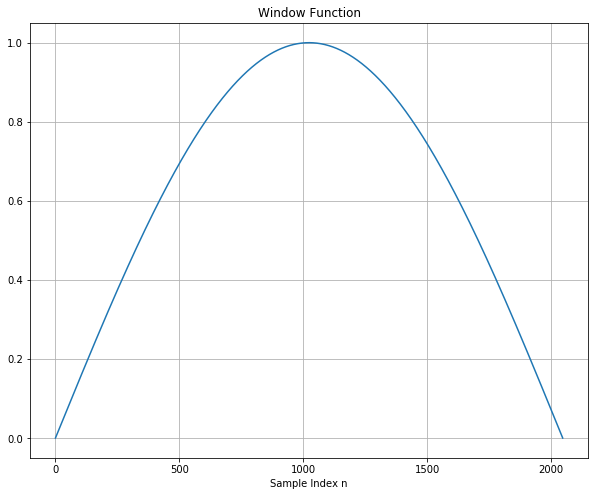

In [ ]:
#Number of subbands:
N=1024

#MDCT sine window:
h=np.sin(np.pi/(2*N)*(np.arange(2*N)+0.5))

#Plot window function:
plt.figure(figsize=(10,8))
plt.plot(h)
plt.title('Window Function')
plt.xlabel('Sample Index n')
plt.grid()

In [ ]:
#Folding Matrix:
Fa=Famatrix(h)

#Delay Matrix D(z):
Dp=zeros((N,N,2))
Dp[:,:,0]=diag(hstack((zeros(int(N/2)),ones(int(N/2)))))
Dp[:,:,1]=diag(hstack((ones(int(N/2)),zeros(int(N/2)))))

Famatrix N= 1024


In [ ]:
#Fa*D(z):
Faz=polmatmult(Fa,Dp)

In [ ]:
def x2polyphase(x,N):
    """Converts input signal x (a row vector) into a
    polyphase row vector
    for blocks of length N"""
    #Number of blocks in the signal:
    L = int(np.floor(max(np.shape(x))/N))
    print("L= ", L)
    xp = np.zeros((1,N,L))
    for m in range(0,L):
        xp[0,:,m] = x[m*N+np.arange(N)]
    return xp

In [ ]:
xp=x2polyphase(x,N)
yp=polmatmult(xp,Faz)

L=  8822


In [ ]:
#Number of blocks:
L=yp.shape[2]

def DCT4(samples):
    """samples : (1D Array) Input samples    
     to be transformed
     Returns:y (1D Array) Transformed  
    output samples
    """
    import numpy as np
    import scipy.fftpack as spfft
    N=len(samples)
    # Initialize
    samplesup=np.zeros(2*N)
    # Upsample signal:
    samplesup[1::2]=samples      
    y = spfft.dct(samplesup,type=3,
    norm='ortho')*np.sqrt(2)
    return y[0:N]


In [ ]:
#Apply DCT4 transform to the rows:
for m in range(L):
    yp[0,:,m]=DCT4(yp[0,:,m])

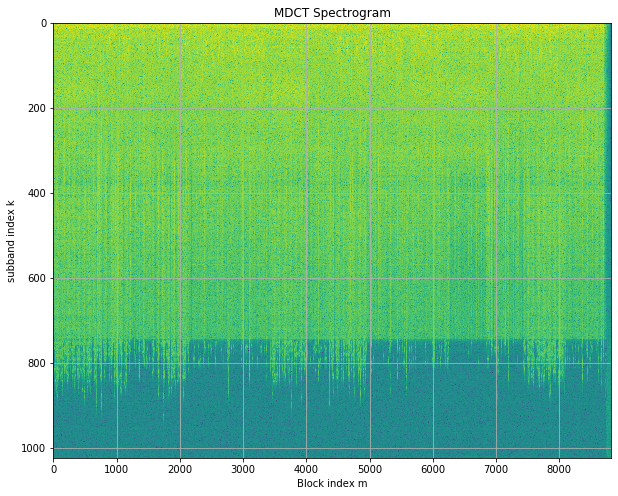

In [ ]:
#Resulting spectrogram image:
plt.figure(figsize=(10,8))
plt.imshow(np.log(abs((yp[0,:,:]+1e-9))), aspect='auto')
plt.title('MDCT Spectrogram')
plt.ylabel('subband index k')
plt.xlabel('Block index m')
plt.grid();

Observe: The highest frequencies are above, at the small subband indices k, and we have only 8822 blocks horizontally, due to critical sampling.

### MDCT Synthesis Filter Bank

From this critically sampled version we can still go back to the original time domain signal, using the synthesis MDCT filter bank for perfect reconstruction (continued from above)

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/xaSokgJHI-8?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

In [ ]:
#Compute the inverse folding matrix for the Synthesis:
Fs=zeros(Fa.shape)
Fs[:,:,0]=np.linalg.inv(Fa[:,:,0])

#apply the inverse transform (which for the DCT4 is identical to the forward transform):
L=yp.shape[2]
#Apply DCT4 (inverse) transform to the rows:
for m in range(L):
    yp[0,:,m]=DCT4(yp[0,:,m])

In [ ]:
#Inverse Delay Matrix with delay:
Dpi=zeros((N,N,2))
Dpi[:,:,1]=diag(hstack((zeros(int(N/2)),ones(int(N/2)))))
Dpi[:,:,0]=diag(hstack((ones(int(N/2)),zeros(int(N/2)))))

In [ ]:
#multiply with inverse delay matrix with delay:
yp=polmatmult(yp,Dpi)
#Multiply with synthesis folding matrix Fs:
xrekp=polmatmult(yp,Fs)

In [ ]:
def polyphase2x(xp):
    """Converts polyphase input signal xp (a row vector) into a
    contiguos row vector
    For block length N, for 3D polyphase representation
    (exponents of z in the third
    matrix/tensor dimension)"""
    #Number of blocks in the signal
    [r,N,L] = np.shape(xp);
    x = np.zeros((1,N*L));
    for m in range(L):
        x[0,m*N+np.arange(N)]=xp[0,:,m]
    return x

In [ ]:
xrek=polyphase2x(xrekp)
xrekp.shape

(1, 1024, 8824)

In [ ]:
xrek.shape

(1, 9035776)

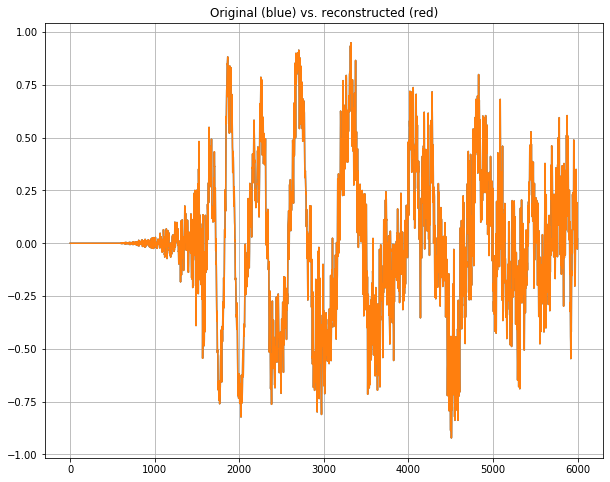

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(x[6000:12000])
plt.plot(xrek[0,6000+1024:12000+1024])
plt.title('Original (blue) vs. reconstructed (red)')
plt.grid()

Observe the delay of 1024 samples between the original an the reconstructed signal (which is the system delay without the blocking delay, since the signal is already in memory).